In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.applications.vgg19 import VGG19
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/normal-vs-military-vehicles/dataset/train')
data_val = tf.keras.utils.image_dataset_from_directory('/kaggle/input/normal-vs-military-vehicles/dataset/validation')
data_test = tf.keras.utils.image_dataset_from_directory('/kaggle/input/normal-vs-military-vehicles/dataset/test')

Found 11170 files belonging to 2 classes.
Found 3491 files belonging to 2 classes.
Found 2792 files belonging to 2 classes.


In [5]:
'''
data = data.map(lambda x,y:(x/255,y))
data_val = data_val.map(lambda x,y:(x,y))
data_test = data_test.map(lambda x,y:(x,y))

'''
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_training_set = data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_set = data_val.map(lambda x, y: (normalization_layer(x), y))

In [24]:
normalized_test_set = data_test.map(lambda x, y: (normalization_layer(x), y))

In [6]:
data_iterator = normalized_training_set.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

In [8]:
batch[1]

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

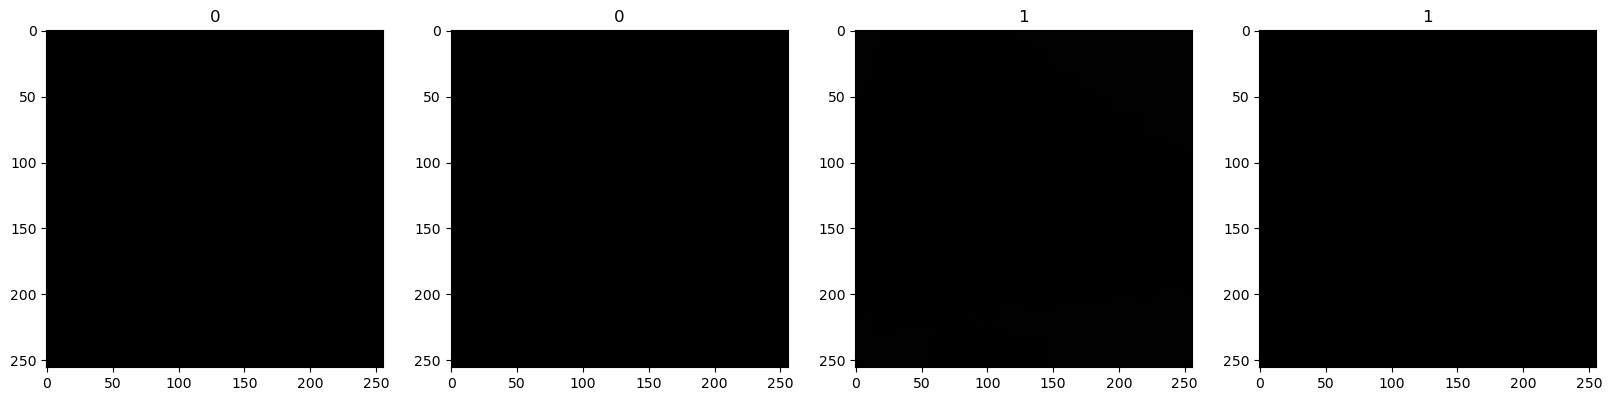

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers,models

In [11]:
vgg = VGG19(input_shape=(256,256,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

modelvgg = models.Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [12]:
opt=keras.optimizers.Adam(learning_rate=0.001)
modelvgg.compile(opt, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
hist = modelvgg.fit(normalized_training_set, epochs=15, validation_data=normalized_val_set,batch_size=16)

Epoch 1/15
350/350 [==============================] - 118s 302ms/step - loss: 0.3071 - accuracy: 0.8696 - val_loss: 0.1948 - val_accuracy: 0.9212
Epoch 2/15
350/350 [==============================] - 110s 314ms/step - loss: 0.1396 - accuracy: 0.9488 - val_loss: 0.2233 - val_accuracy: 0.9086
Epoch 3/15
350/350 [==============================] - 111s 317ms/step - loss: 0.1016 - accuracy: 0.9645 - val_loss: 0.1376 - val_accuracy: 0.9453
Epoch 4/15
350/350 [==============================] - 111s 317ms/step - loss: 0.0678 - accuracy: 0.9809 - val_loss: 0.1403 - val_accuracy: 0.9419
Epoch 5/15
350/350 [==============================] - 92s 261ms/step - loss: 0.0477 - accuracy: 0.9891 - val_loss: 0.1291 - val_accuracy: 0.9487
Epoch 6/15
350/350 [==============================] - 111s 318ms/step - loss: 0.0352 - accuracy: 0.9933 - val_loss: 0.1260 - val_accuracy: 0.9499
Epoch 7/15
350/350 [==============================] - 111s 317ms/step - loss: 0.0253 - accuracy: 0.9979 - val_loss: 0.1494 - 

# Plot Performance

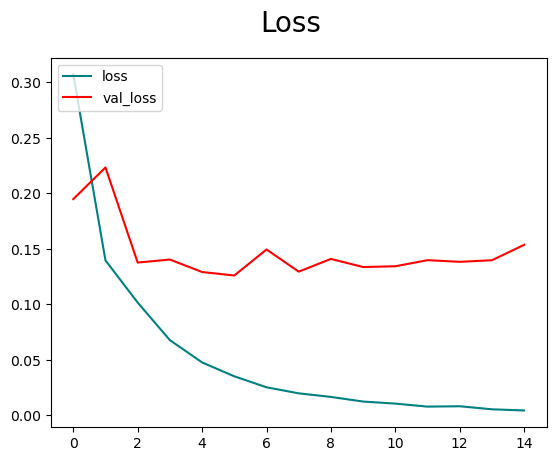

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

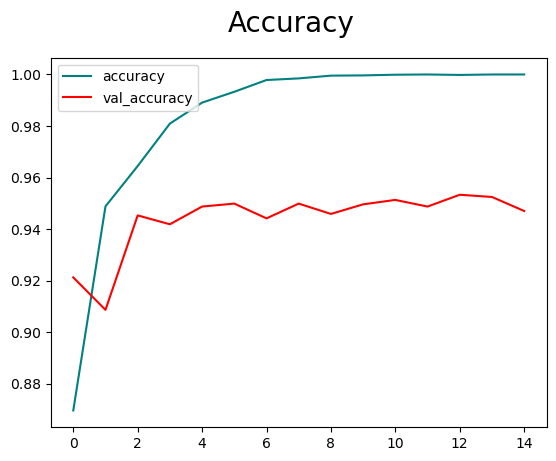

In [16]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [25]:
loss, accuracy = modelvgg.evaluate(normalized_test_set)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

88/88 [==============================] - 20s 222ms/step - loss: 0.1868 - accuracy: 0.9355
Loss:  0.18678466975688934
Accuracy:  0.9355300664901733


In [28]:
import cv2
import numpy as np
import os
true_values = []
predictions = []
sayac = 0
path = "/kaggle/input/normal-vs-military-vehicles/dataset/test"
class_names = os.listdir(path)
for i in class_names:
    for b in os.listdir(os.path.join(path, i)):
        true_values.append(sayac)
        struct = path + "/" + i + "/" + b 
        img = cv2.imread(struct)
        resize = tf.image.resize(img, (256,256))
        yhat = modelvgg.predict(np.expand_dims(resize/255, 0), verbose = 0)
        if yhat > 0.5: 
            predictions.append(1)
        else:
            predictions.append(0)
    sayac+=1

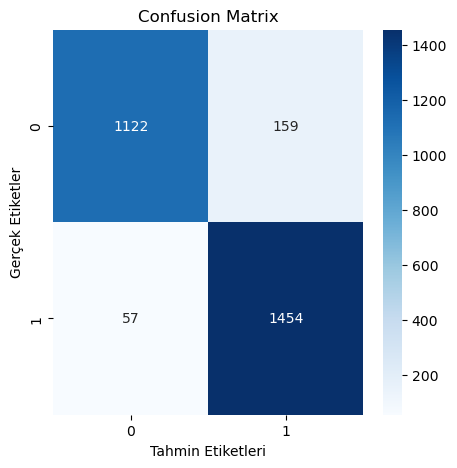

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Kafa karışıklığı matrisini hesapla
cm = confusion_matrix(true_values, predictions)

# Kafa karışıklığı matrisini görselleştir
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Etiketleri")
plt.ylabel("Gerçek Etiketler")
plt.show()